# 以下是先执行 part3 的代码：

In [1]:

'''skip-gram方法训练词向量, 给定中心词预测上下文'''

from torch import nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud
from torch.nn.parameter import Parameter
from collections import Counter
import numpy as np
import random
import math
import pandas as pd
from paddlenlp import Taskflow
import json
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity  # 余弦相似度函数


# Dataloader
class Dataset(tud.Dataset):  # 继承tud.Dataset父类

    def __init__(self, text, word_to_idx, idx_to_word, word_freqs, word_counts):
        super(Dataset, self).__init__()
        self.text_encoded = [word_to_idx.get(t, VOCAB_SIZE - 1) for t in text]
        self.text_encoded = torch.Tensor(self.text_encoded).long()
        self.word_to_idx = word_to_idx
        self.idx_to_word = idx_to_word
        self.word_freqs = torch.Tensor(word_freqs)
        self.word_counts = torch.Tensor(word_counts)

    def __len__(self):
        return len(self.text_encoded)

    def __getitem__(self, idx):
        ''' 这个function返回以下数据用于训练
            - 中心词
            - 这个单词附近的(positive)单词
            - 随机采样的K个单词作为negative sample
        '''
        center_word = self.text_encoded[idx]
        pos_indices = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1))
        pos_indices = [i % len(self.text_encoded) for i in pos_indices]
        pos_words = self.text_encoded[pos_indices]
        # replacement=True有放回的取
        neg_words = torch.multinomial(self.word_freqs, K * pos_words.shape[0], replacement=True)

        return center_word, pos_words, neg_words

    # skip-gram model


class EmbeddingModel(nn.Module):

    def __init__(self, vocab_size, embed_size):
        super(EmbeddingModel, self).__init__()
        self.vocab_size = vocab_size  # 30000
        self.embed_size = embed_size  # 100
        # 模型输入，输出是两个一样的矩阵参数nn.Embedding(30000, 100)
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size, sparse=False)
        self.out_embed = nn.Embedding(self.vocab_size, self.embed_size, sparse=False)
        # 模型权重初始化
        initrange = 0.5 / self.embed_size
        self.in_embed.weight.data.uniform_(-initrange, initrange)
        self.out_embed.weight.data.uniform_(-initrange, initrange)

    def forward(self, input_labels, pos_labels, neg_labels):
        '''
        input_labels: 中心词,         [batch_size]
        pos_labels: 中心词周围词       [batch_size * (c * 2)]
        neg_labelss: 中心词负采样单词  [batch_size, (c * 2 * K)]
        return: loss, 返回loss        [batch_size]
        '''
        batch_size = input_labels.size(0)
        input_embedding = self.in_embed(input_labels)  # B * embed_size
        pos_embedding = self.out_embed(pos_labels)  # B * (2C) * embed_size
        neg_embedding = self.out_embed(neg_labels)  # B * (2*C*K) * embed_size

        # torch.bmm()为batch间的矩阵相乘（b,n.m)*(b,m,p)=(b,n,p)
        log_pos = torch.bmm(pos_embedding, input_embedding.unsqueeze(2)).squeeze()  # B * (2*C)
        log_neg = torch.bmm(neg_embedding, -input_embedding.unsqueeze(2)).squeeze()  # B * (2*C*K)

        # 下面loss计算就是论文里的公式
        log_pos = F.logsigmoid(log_pos).sum(1)  # batch_size
        log_neg = F.logsigmoid(log_neg).sum(1)  # batch_size
        loss = log_pos + log_neg  # 正样本损失和负样本损失和尽量最大
        return -loss

        # 模型训练有两个矩阵self.in_embed和self.out_embed, 作者认为输入矩阵比较好

    def input_embeddings(self):
        return self.in_embed.weight.data.cpu().numpy()


def evaluate(filename, embedding_weights):
    # embedding_weights是训练之后的embedding向量
    model_similarity = []

def openreadtxt(file_name):
    data = []
    file = open(file_name, 'r', encoding='UTF-8')
    file_data = file.readlines()
    for row in file_data:
        data.append(row)
    return data

    for i in data.iloc[:, 0:2].index:
        word1, word2 = data.iloc[i, 0], data.iloc[i, 1]
        if word1 not in word_to_idx or word2 not in word_to_idx:
            continue
        else:
            word1_idx, word2_idx = word_to_idx[word1], word_to_idx[word2]
            word1_embed, word2_embed = embedding_weights[[word1_idx]], embedding_weights[[word2_idx]]
            # 在分别取出这两个单词对应的embedding向量，具体为啥是这种取出方式[[word1_idx]]，可以自行研究
            model_similarity.append(float(sklearn.metrics.pairwise.cosine_similarity(word1_embed, word2_embed)))
            # 用余弦相似度计算这两个100维向量的相似度。这个是模型算出来的相似度


    return scipy.stats.spearmanr(model_similarity)  # model_similarity


if __name__ == '__main__':
    use_cuda = torch.cuda.is_available()
    random.seed(1234)
    np.random.seed(1234)
    torch.manual_seed(1234)
    if use_cuda:
        torch.cuda.manual_seed(1234)

    # 超参数设置
    K = 10  # 负样本随机采样数量
    C = 3  # 周围单词的数量
    NUM_EPOCHS = 2
    VOCAB_SIZE = 30000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.2
    EMBEDDING_SIZE = 100
    LOG_FILE = "word_embedding.log"

    with open("D:/try/split_text/split_0.txt", "r", encoding='gb18030', errors='ignore') as file:
        text = file.read()

    text = [w for w in (text.lower()).split()]
    vocab = dict(Counter(text).most_common(VOCAB_SIZE - 1))
    vocab["<unk>"] = len(text) - np.sum(list(vocab.values()))
    idx_to_word = [word for word in vocab.keys()]
    word_to_idx = {word: i for i, word in enumerate(idx_to_word)}

    word_counts = np.array([count for count in vocab.values()], dtype=np.float32)
    word_freqs = word_counts / np.sum(word_counts)
    word_freqs = word_freqs ** (3. / 4.)
    word_freqs = word_freqs / np.sum(word_freqs)  # 用来做 negative sampling

    dataset = Dataset(text, word_to_idx, idx_to_word, word_freqs, word_counts)
    dataloader = tud.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    # print(next(iter(dataloader))[0].shape) # 中间词维度data
    # print(next(iter(dataloader))[1].shape) # 周围词维度
    # print(next(iter(dataloader))[2].shape) # 负样本维度

    model = EmbeddingModel(VOCAB_SIZE, EMBEDDING_SIZE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    if use_cuda:
        model = model.cuda()

    # training
    for e in range(NUM_EPOCHS):
        for i, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
            input_labels = input_labels.long()
            pos_labels = pos_labels.long()
            neg_labels = neg_labels.long()
            if use_cuda:
                input_labels = input_labels.cuda()
                pos_labels = pos_labels.cuda()
                neg_labels = neg_labels.cuda()

            optimizer.zero_grad()
            loss = model(input_labels, pos_labels, neg_labels).mean()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                with open(LOG_FILE, "a") as fout:
                    fout.write("epoch: {}, iter: {}, loss: {}\n".format(e, i, loss.item()))
                    print("epoch: {}, iter: {}, loss: {}".format(e, i, loss.item()))
            '''
            if i % 2000 == 0:
                embedding_weights = model.input_embeddings()  # 取出训练中的in_embed词向量
                # 在三个词文本上评估词向量
                sim_simlex = evaluate("simlex-999.txt", embedding_weights)
                sim_men = evaluate("men.txt", embedding_weights)
                sim_353 = evaluate("wordsim353.csv", embedding_weights)

                with open(LOG_FILE, "a") as fout:
                    print("epoch: {}, iter: {}, simlex-999: {}, men: {}, sim353: {}, nearest to monster: {}\n".format(
                        e, i, sim_simlex, sim_men, sim_353, np.find_nearest("monster")))
                    fout.write(
                        "epoch: {}, iter: {}, simlex-999: {}, men: {}, sim353: {}, nearest to monster: {}\n".format(
                            e, i, sim_simlex, sim_men, sim_353, np.find_nearest("monster")))
            '''
        embedding_weights = model.input_embeddings()  # 调用最终训练好的embeding词向量
        torch.save(model.state_dict(), 'model_embedding.th')  # 模型保存

epoch: 0, iter: 0, loss: 45.747711181640625
epoch: 1, iter: 0, loss: 45.74749755859375


# 以下是part4.1：
## Track 4.1 (5%): Visualise the word representations by t-SNE

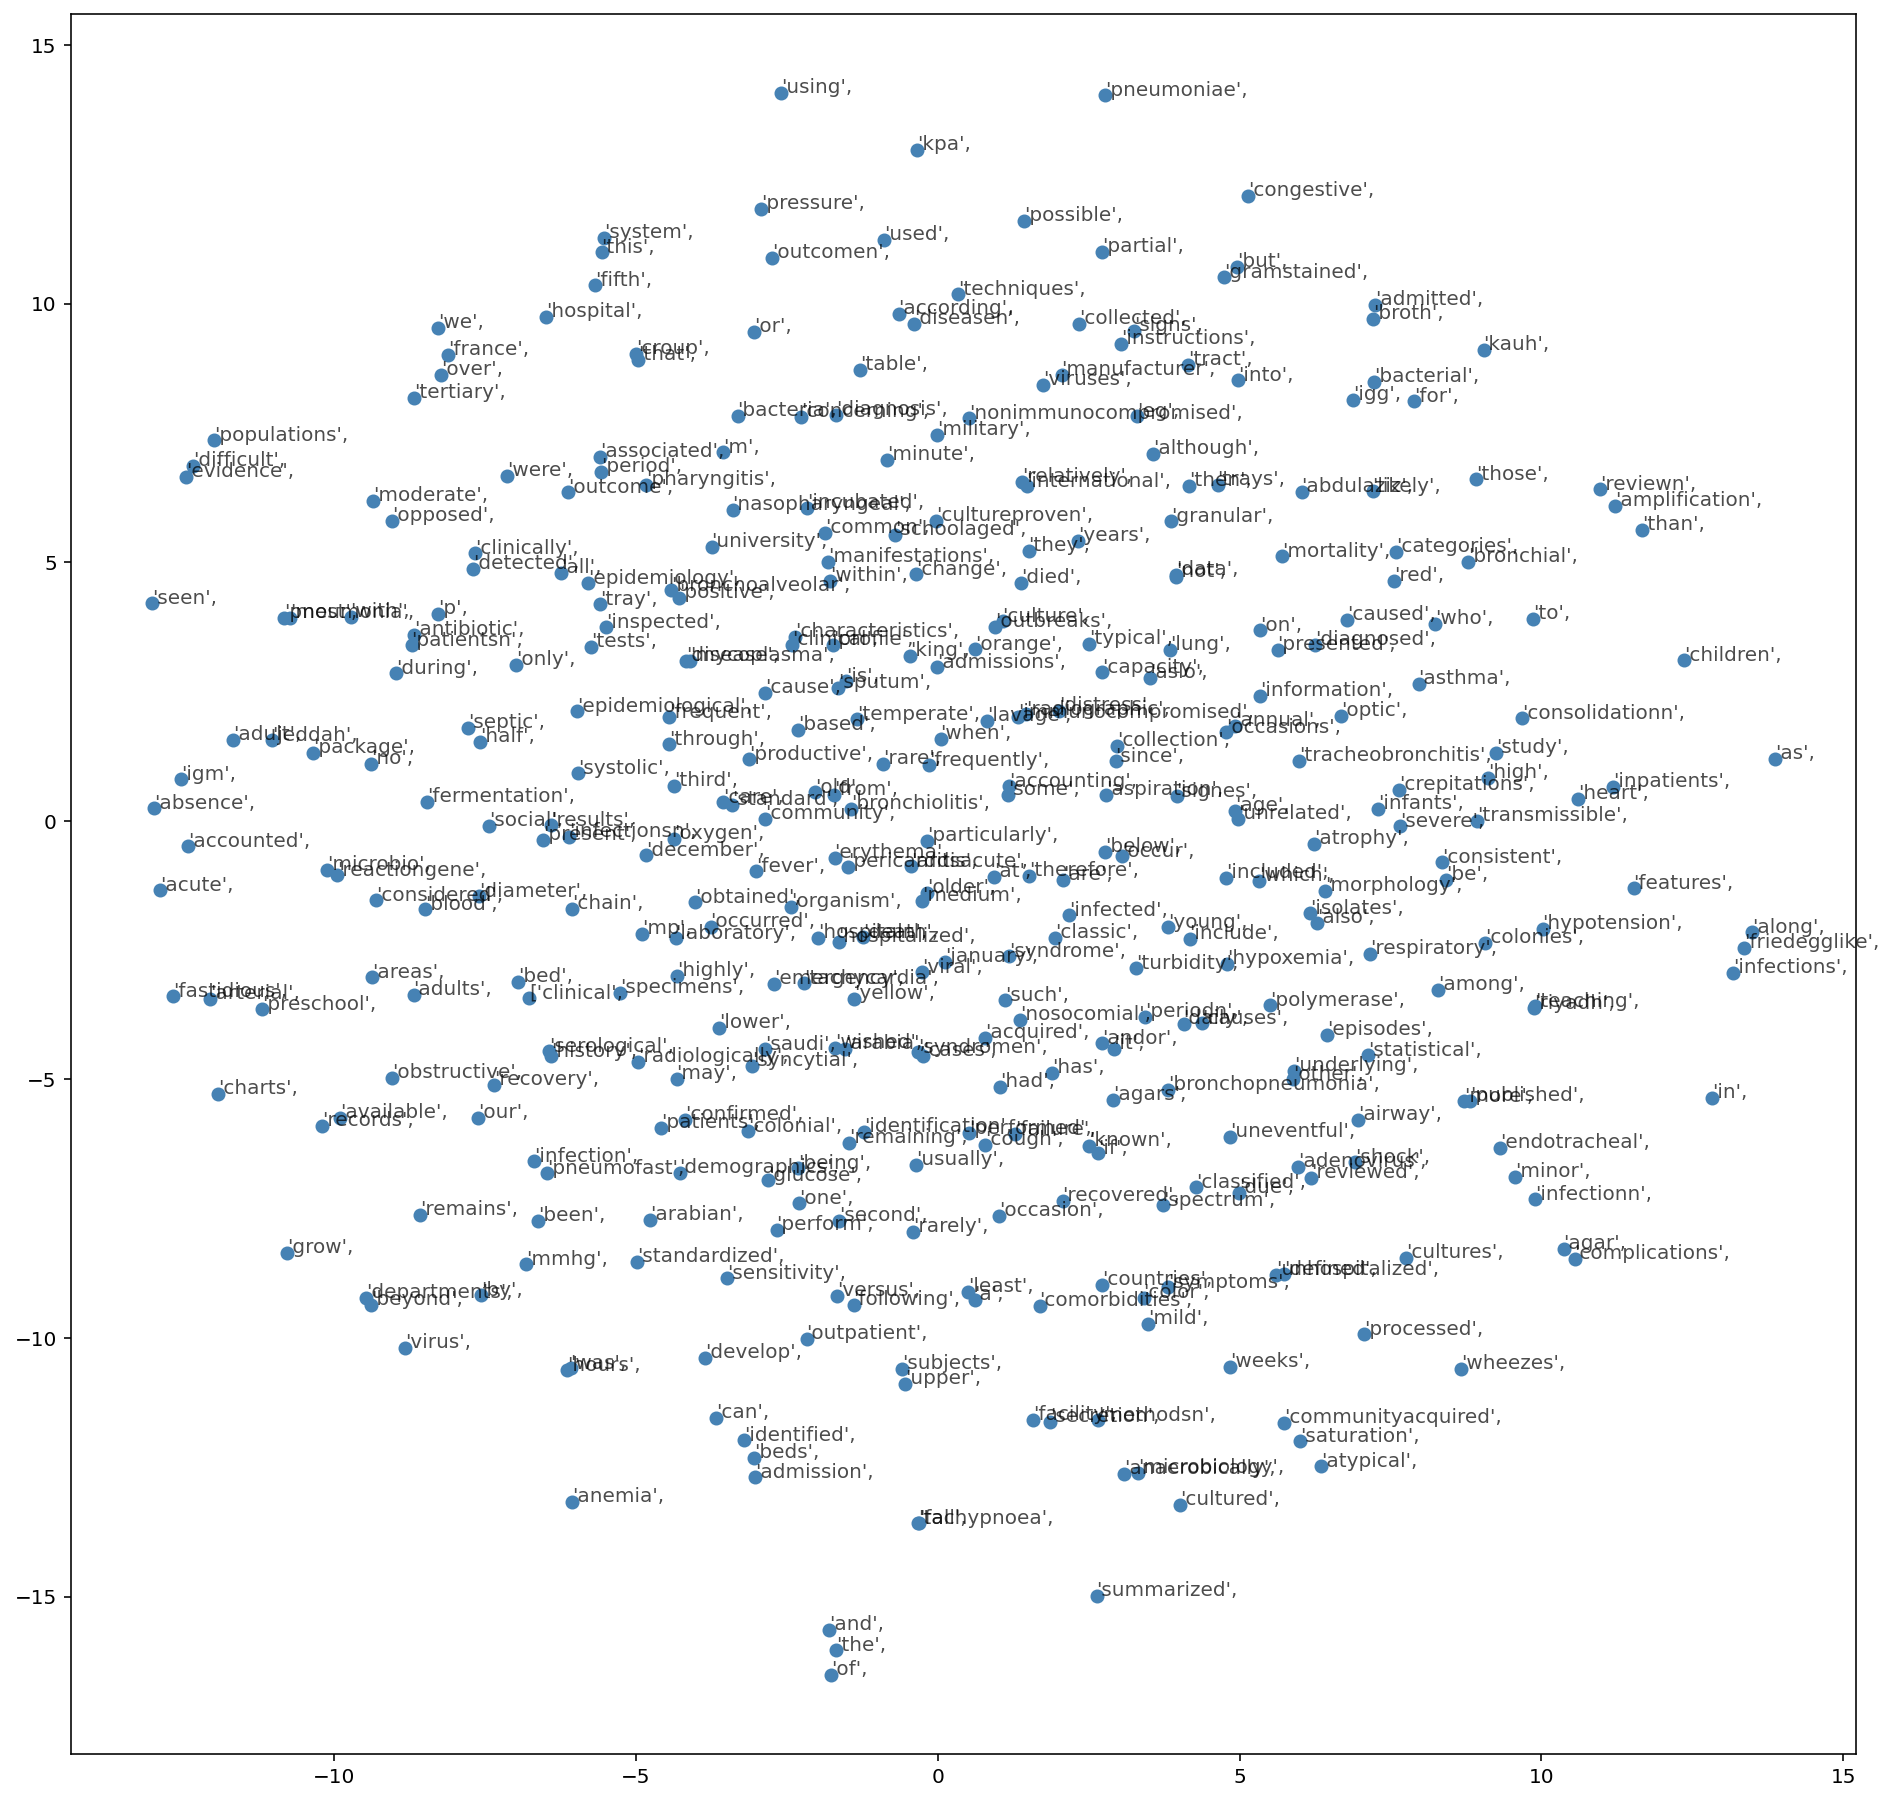

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embedding_weights[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(idx_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# 存在问题：训练出来的loss很大，效果不好